In [1]:
from data_v2 import *
import numpy as np
import fnmatch
from mvar import *

In [2]:
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ', 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
         'WIKI/JPM', 'WIKI/XOM', 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']

models = {'ffnn_deterministic', 'ffnn_bayesian', 'lstm_deterministic', 'lstm_bayesian', 'gru_deterministic', 'gru_bayesian', 'tanh_deterministic', 'tanh_bayesian', 'relu_deterministic', 'relu_bayesian' , 'var_deterministic', 'var_bayesian'}
models_justf = {'ffnn', 'lstm', 'gru', 'tanh', 'relu', 'var'} 
time_period = 'daily' #{'daily', 'weekly', 'monthly', 'quarterly'}

n_steps = 15#{7, 15, 30, 60}
#stocks = ['WIKI/BAC']
gamma = 1
n_stocks = len(stocks)
batch_size = 100
#gamma = [0, 1, 20, 500]
bayes_iterations = 100

n_epochs = 3000



In [3]:
df =np.array(get_data(stocks= stocks, col = time_period))
X,y = split_sequence(df, n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

In [4]:
def test_dim(col):
    df =np.array(get_data(stocks= stocks, col = col))
    X,y = split_sequence(df, n_steps)
    X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)
    return y_test.shape[0]

In [5]:
def just_data(stocks,col):
    df =np.array(get_data(stocks= stocks, col = "daily"))
    X,y = split_sequence(df, n_steps)
    X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)
    return X_test

In [6]:
n_stocks = len(stocks)
var_hist = []

for tstamp in range(X_test.shape[0]):
    var_hist.append(np.asmatrix(np.cov(X_test[tstamp, :, :], rowvar = False)))

for mod in models_justf:
            path = './results/n_stocks/' + "daily" + '_' + "15" + '_'
            np.savez(str(path + '_' + '_' + mod + '_deterministic_' + 'var'), var_hist)


###### MSE

In [7]:
from collections import defaultdict
import os

groups = defaultdict(list)

for filename in os.listdir('./results/n_stocks/'):
    if fnmatch.fnmatch(filename, '*mse*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)
        
mse_to_avg = []
for key, fnames in groups.items():
    mse_load = []
    for f in range(len(fnames)):
        val = np.load(str('./results/n_stocks/' + fnames[f]))
        mse_load.append(val.f.arr_0)
    mse_to_avg.append((key[0:3], round(np.mean(mse_load),5)))

for aaa in range(len(mse_to_avg)):
    print(round(mse_to_avg[aaa][1],5))

0.00024
0.00024
0.00071
0.00042
0.00023
0.00036
0.00023
0.00028
0.00023
0.00029
0.00023
0.00023


## Log Likelihood

In [22]:
from collections import defaultdict

groups = defaultdict(list)

for filename in os.listdir('./results/n_stocks/'):
    if fnmatch.fnmatch(filename, '*loglik*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)
        
log_to_avg = []
for key, fnames in groups.items():
    log_load = []
    for f in range(len(fnames)):
        val = np.load(str('./results/n_stocks/' + fnames[f]))
        log_load.append(val.f.arr_0)
    log_to_avg.append((key[0:3], round(np.mean(mse_load),15)))

## Mean, Sigma

In [8]:
from collections import defaultdict
import tqdm


groups = defaultdict(list)

for filename in os.listdir('./results/n_stocks/'):
    if fnmatch.fnmatch(filename, '*mu*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)
        
y_hat = []
for key, fnames in tqdm.tqdm(groups.items()):
    mu_per_group = np.empty((test_dim(key[0]), n_stocks))
    kk = 0
    for f in range(len(fnames)):
        val = np.load(str('./results/n_stocks/' + fnames[f]))
        mu_per_group[:,kk] = val.f.arr_0
        kk += 1
    y_hat.append(mu_per_group)
     

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [06:21<00:00, 32.68s/it]


In [9]:
from collections import defaultdict

groups = defaultdict(list)

for filename in os.listdir('./results/n_stocks/'):
    if fnmatch.fnmatch(filename, '*var.npz'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)
        
sigma_hat = []
for key, fnames in tqdm.tqdm(groups.items()):
    if key[2] == 'deterministic':
        var_hist = np.load(str('./results/n_stocks/' + key[0] + '_15___ffnn_deterministic_var.npz'))
        var_hist = var_hist.f.arr_0
        sigma_hat.append(var_hist)
    
    elif key[2] == 'bayesian':
        var_hist = np.load(str('./results/n_stocks/' + key[0] + '_15___ffnn_deterministic_var.npz'))
        var_hist = var_hist.f.arr_0
        dim_test = test_dim(key[0])
        sigma_per_group = np.empty((dim_test, n_stocks))
        kk = 0
        covar_bayes = np.empty((dim_test, n_stocks, n_stocks))
        for fa in range(len(fnames)):
            val = np.load(str('./results/n_stocks/' + fnames[fa]))
            sigma_per_group[:,kk] = val.f.arr_0
            kk += 1
            
        for m in range(dim_test):
            covar_bayes[m,:,:] = np.diag(sigma_per_group[m])
            np.fill_diagonal(var_hist[m], np.diag(covar_bayes[m]))
        
        sigma_hat.append(var_hist)
     

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:43<00:00, 18.64s/it]


## It's important to make sure mu and sigma lists are ordered in the same way. Hence we look for to order indices in sigma_hat in the same way as in y_hat.

In [10]:
groups = defaultdict(list)

for filename in os.listdir('./results/n_stocks/'):
    if fnmatch.fnmatch(filename, '*mu*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)
        

mu_names = []
for key in groups.keys():
    mu_names.append(key[:3])

In [11]:
groups = defaultdict(list)

for filename in os.listdir('./results/n_stocks/'):
    if fnmatch.fnmatch(filename, '*var.npz'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)


var_names = []
for key in groups.keys():
    var_names.append(key[:3])

In [12]:
idxs = []
for l in range(len(mu_names)):
    indices = [i for i, x in enumerate(var_names) if x == mu_names[l]]
    idxs.append(indices[0])

## Now that we have mus and sigmas we should run a loop and calculate portfolio weights

#### First step is to subset the the y_hat and sigma_hat in 4 sets representing the time period of calculation. Then we will get 4 sets, one for each panel in the graph.

### n stocks = 4

In [16]:
mu_1 = []
idxs_pick_1 = []

for ne in range(len(y_hat)):
    mu_1.append(y_hat[ne][:,:4])
    idxs_pick_1.append(idxs[ne])
    
    
    
sigma_1 = []
for ne in idxs_pick_1:
    sigma_1.append(sigma_hat[ne][:,:4,:4])
    

In [61]:
def log_likelihood(mean, sigma, data):
        sigma = np.sqrt(np.diagonal(sigma, axis1 = 1, axis2 = 2))
        s = (data - mean) ** 2 / (2 * (sigma ** 2))
        pdfs = np.exp(- s)
        pdfs /= np.sqrt(2 * np.pi) * sigma
        return np.nansum(np.ma.log(pdfs))/len(data)
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']#, 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
   #      'WIKI/JPM', 'WIKI/XOM', 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']
n_stocks = len(stocks)

return_period = 'daily'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = 15)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_4 = []
for ne in range(len(mu_1)):
    log_lik_4.append(log_likelihood(mu_1[ne].squeeze(), sigma_1[ne], y_test.squeeze()))
    
for xx in range(len(log_lik_4)):
    print(round(log_lik_4[xx], 4))

8.3754
11.0168
-163.762
5.8236
-217.7734
6.4113
-65.3047
10.3266
-69.9845
8.1366
-529.9647
10.9698


### n stocks = 7

In [19]:
mu_2 = []
idxs_pick_2 = []

for ne in range(len(y_hat)):
    mu_2.append(y_hat[ne][:,:7])
    idxs_pick_2.append(idxs[ne])
    
    
    
sigma_2 = []
for ne in idxs_pick_2:
    sigma_2.append(sigma_hat[ne][:,:7,:7])
    

In [60]:
def log_likelihood(mean, sigma, data):
        sigma = np.sqrt(np.diagonal(sigma, axis1 = 1, axis2 = 2))
        s = (data - mean) ** 2 / (2 * (sigma ** 2))
        pdfs = np.exp(- s)
        pdfs /= np.sqrt(2 * np.pi) * sigma

        return np.sum(np.ma.log(pdfs))/len(data)


stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ', 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD']#, 'WIKI/HPQ',
   #      'WIKI/JPM', 'WIKI/XOM', 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']

return_period = 'daily'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = 15)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_7 = []
for ne in range(len(mu_2)):
    log_lik_7.append(log_likelihood(mu_2[ne].squeeze(), sigma_2[ne].squeeze(), y_test.squeeze()))
    print(round(log_lik_7[ne], 4))

14.5812
18.6021
-273.0377
10.338
-472.9857
12.7243
-118.3312
17.038
-132.2266
15.8107
-924.1922
18.6599


### n stocks = 10

In [15]:
mu_3 = []
idxs_pick_3 = []

for ne in range(len(y_hat)):
    mu_3.append(y_hat[ne][:,:10])
    idxs_pick_3.append(idxs[ne])
    
    
    
sigma_3 = []
for ne in idxs_pick_3:
    sigma_3.append(sigma_hat[ne][:,:10,:10])
    

In [57]:
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ', 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
         'WIKI/JPM', 'WIKI/XOM']#, 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']

return_period = 'daily'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = 15)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_10 = []
for ne in range(len(mu_3)):
    log_lik_10.append(log_likelihood(mu_3[ne].squeeze(), sigma_3[ne].squeeze(), y_test.squeeze()))
    
log_lik_10

[18.206567502606642,
 26.26170058785404,
 -406.6276633057722,
 17.0470500385632,
 -796.5047532328505,
 20.060516246893357,
 -207.15614685191377,
 24.0217642913829,
 -199.90619256848953,
 23.495843385782976,
 -1278.542260279154,
 26.340515819273794]

In [58]:
for aaa in range(len(log_lik_10)):
    print(round(log_lik_10[aaa],4))

18.2066
26.2617
-406.6277
17.0471
-796.5048
20.0605
-207.1561
24.0218
-199.9062
23.4958
-1278.5423
26.3405


### n stocks = 15

In [62]:
mu_4 = []
idxs_pick_4 = []

for ne in range(len(y_hat)):
    mu_4.append(y_hat[ne][:,:15])
    idxs_pick_4.append(idxs[ne])
    
    
    
sigma_4 = []
for ne in idxs_pick_4:
    sigma_4.append(sigma_hat[ne][:,:15,:15])
    

In [63]:
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ', 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
         'WIKI/JPM', 'WIKI/XOM', 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']

return_period = 'daily'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = 15)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_15 = []
for ne in range(len(mu_4)):
    log_lik_15.append(log_likelihood(mu_4[ne].squeeze(), sigma_4[ne].squeeze(), y_test.squeeze()))
    
for aaa in range(len(log_lik_15)):
    print(round(log_lik_15[aaa],4))

29.6756
40.0461
-615.4641
27.2242
-1256.2843
31.6931
-327.4853
37.5928
-309.6312
37.5374
-1897.1417
40.3461


#### At last! Portfolio Optimization!

In [61]:
y_test[0,:4]

array([[0.00308452],
       [0.00525691],
       [0.010314  ],
       [0.00506586]])

In [17]:
from mvar import *


stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']#, 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
   #      'WIKI/JPM', 'WIKI/XOM', 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']

return_period = 'daily'
df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = 15)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_1[0].shape[0]).index)

w0 = [1/mu_1[0].shape[1]] * mu_1[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_1 = []
exprets_1 = []
pfvar_1 = []

for i_1 in range(len(mu_1)): 
    historical_weights = []    
    for ts in range(len(mu_1[i_1])):
        hv = mv_portfolio(returns = np.asmatrix(mu_1[i_1][ts]).T, variance = sigma_1[i_1][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma)
        if not any(np.isnan(hv)):
            historical_weights.append(hv)
        else:
            historical_weights.append(historical_weights[ts - 1])
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0,:4].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n,:4].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)
        
    portfolio_1.append(portfolio_value)

    
portfolio_1 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_1)).T)
portfolio_1 = pd.DataFrame(portfolio_1).set_index(dates)



In [18]:
from benchmark_2 import *
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']

port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'daily', gamma)
portfolio_1 = portfolio_1.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'daily')
portfolio_1 = portfolio_1.assign(equal=pd.Series(port_equal.squeeze()).values)

4


In [19]:
from mvar import *

stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ', 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD']#, 'WIKI/HPQ',
   #      'WIKI/JPM', 'WIKI/XOM', 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']


df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = 15)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_2[0].shape[0]).index)

w0 = [1/mu_2[0].shape[1]] * mu_2[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_2 = []
exprets_2 = []
pfvar_2 = []

for i_2 in range(len(mu_2)): 
    historical_weights = []    
    for ts in range(len(mu_2[i_2])):
        historical_weights.append(mv_portfolio(returns = np.asmatrix(mu_2[i_2][ts]).T, variance = sigma_2[i_2][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma))
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0,:7].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n,:7].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)
        
    portfolio_2.append(portfolio_value)
    
portfolio_2 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_2)).T)
portfolio_2 = pd.DataFrame(portfolio_2).set_index(dates)



In [20]:
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ', 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD']

port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'daily', gamma)
portfolio_2 = portfolio_2.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'daily')
portfolio_2 = portfolio_2.assign(equal=pd.Series(port_equal.squeeze()).values)

7


In [21]:
from mvar import *

stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ', 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
         'WIKI/JPM', 'WIKI/BAC']#, 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']


df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = 15)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_3[0].shape[0]).index)

w0 = [1/mu_3[0].shape[1]] * mu_3[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_3 = []
exprets_3 = []
pfvar_3 = []

for i_3 in range(len(mu_3)): 
    historical_weights = []    
    for ts in range(len(mu_3[i_3])):
        hv = mv_portfolio(returns = np.asmatrix(mu_3[i_3][ts]).T, variance = sigma_3[i_3][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma)
        if not any(np.isnan(hv)):
            historical_weights.append(hv)
        else:
            historical_weights.append(historical_weights[ts - 1])
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0, :10].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n, :10].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)
        
    portfolio_3.append(portfolio_value)
    
portfolio_3 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_3)).T)
portfolio_3 = pd.DataFrame(portfolio_3).set_index(dates)


In [22]:
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ', 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
         'WIKI/JPM', 'WIKI/BAC']#, 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']

port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'daily', gamma)
portfolio_3 = portfolio_3.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'daily')
portfolio_3 = portfolio_3.assign(equal=pd.Series(port_equal.squeeze()).values)

10


In [23]:
from mvar import *

stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ', 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
         'WIKI/JPM', 'WIKI/XOM', 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']


df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = 15)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_4[0].shape[0]).index)

w0 = [1/mu_4[0].shape[1]] * mu_4[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_4 = []
exprets_4 = []
pfvar_4 = []

for i_4 in range(len(mu_4)): 
    historical_weights = []    
    for ts in range(len(mu_4[i_4])):
        historical_weights.append(mv_portfolio(returns = np.asmatrix(mu_4[i_4][ts]).T, variance = sigma_4[i_4][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma))
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0, :15].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n, :15].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)
        
    portfolio_4.append(portfolio_value)
    
portfolio_4 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_4)).T)
portfolio_4 = pd.DataFrame(portfolio_4).set_index(dates)



In [24]:
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ', 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
         'WIKI/JPM', 'WIKI/XOM', 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']

port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'daily', gamma)
portfolio_4 = portfolio_4.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'daily')
portfolio_4 = portfolio_4.assign(equal=pd.Series(port_equal.squeeze()).values)

15


### Time for some graph magic

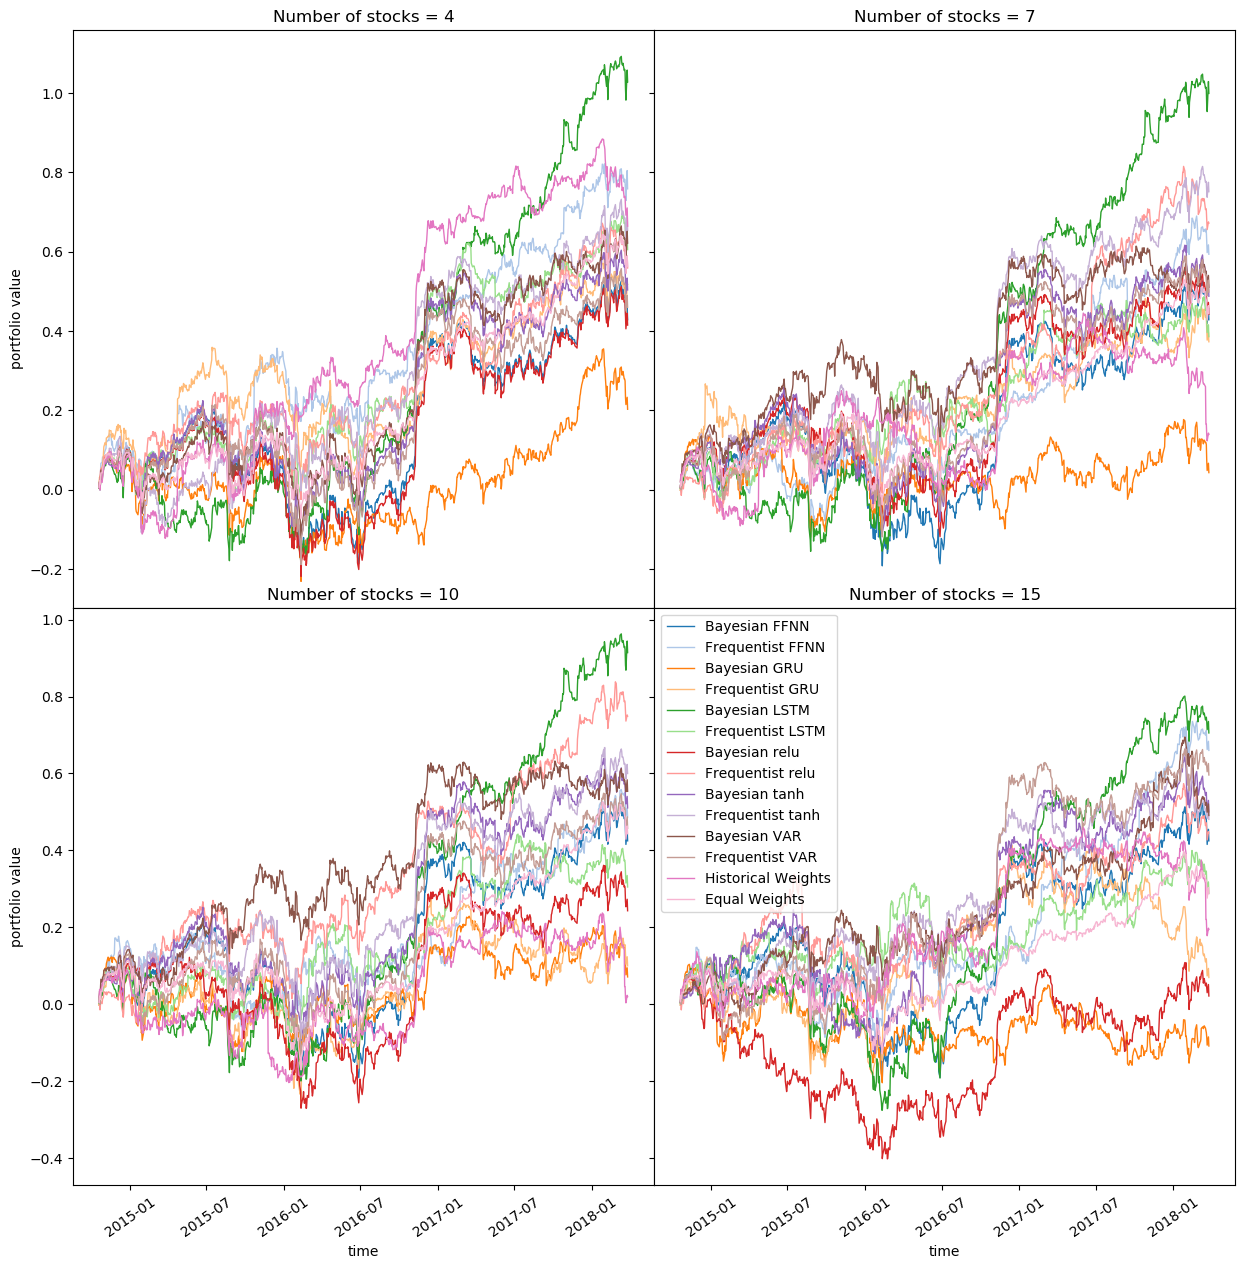

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = 20

cm = plt.get_cmap('tab20')





plt.style.use('default')
plt.rc('lines', linewidth= 1.0)
#plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(2, 2, figsize=(15,15), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, linewidth= 100)

#xfmt = mdates.DateFormatter('%Y-%m-%d')

(ax1, ax2), (ax3, ax4) = axs
#fig.suptitle('Sharing x per column, y per row')
ax1.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
p1 = ax1.plot(portfolio_1)
ax1.set_title('Number of stocks = 4')
#ax1.set_xticklabels([df.index[:100]])
ax2.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax2.plot(portfolio_2)
ax2.set_title('Number of stocks = 7')
ax3.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax3.plot(portfolio_3)
ax3.set_title('Number of stocks = 10')
ax4.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

ax4.plot(portfolio_4)
ax4.set_title('Number of stocks = 15')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='portfolio value')
    ax.label_outer()
    ax.xaxis.set_tick_params(rotation=35)
    


ax.legend((p1), ('Bayesian FFNN', 'Frequentist FFNN', 'Bayesian GRU', 'Frequentist GRU',
                'Bayesian LSTM', 'Frequentist LSTM', 'Bayesian relu', 'Frequentist relu',
                'Bayesian tanh', 'Frequentist tanh', 'Bayesian VAR', 'Frequentist VAR',
                'Historical Weights', 'Equal Weights'), loc='best', shadow=False)

In [51]:
from collections import defaultdict
import os

groups = defaultdict(list)

for filename in os.listdir('./results/n_stocks/ll/mse3/'):
    if fnmatch.fnmatch(filename, '*mse*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)
        
mse_to_avg = []
for key, fnames in groups.items():
    mse_load = []
    for f in range(len(fnames)):
        val = np.load(str('./results/n_stocks/ll/mse3/' + fnames[f]))
        mse_load.append(val.f.arr_0)
    mse_to_avg.append((key[0:3], round(np.mean(mse_load),5)))

for aaa in range(len(mse_to_avg)):
    print(round(mse_to_avg[aaa][1],5))

0.00026
0.00027
0.0004
0.00042
0.00025
0.00036
0.00025
0.00031
0.00025
0.00025
0.00025
0.00025
